#### Context: PoS rewards
Proof-of-Stake (PoS) realizes Sybil resistance by exclusively allocating validation work, and corresponding compensation, to service-providers who have locked non-trivial sums of value (hereafter _stakers_). Game theoretic devices, which coordinate, mediate and penalize stakers, are built upon this eligibility prerequisite of provably committed capital. Heir apparent to energy-inefficient predecessors, Proof-of-Stake protocols have recently come under increasing academic scrutiny – including the mechanisms which incentivize staker participation, and the long-term economic outcomes of flawed reward allocation functions in particular.

#### "Variable incentive" model
PoS rewards are typically generated by minting new units of the network’s native token and distributing them exclusively to active stakers. This implies that the reward's value is contrived via the dilution of token holdings belonging to _non-recipients_. The percentage that the circulating token supply is expected to grow per year, through the issuance of new tokens as rewards, is commonly referred to as the nominal inflation rate ($I_{nom}$). 

The central focus of this notebook is what we describe as the _variable incentive_ model. At any given instance of reward generation and issuance, the size of the reward received by any one staker (and their delegators) varies based on the percentage of tokens staked out of the entire supply in that instance – the staking rate ($S_{rate}$). The staking rate reflects the total capital commitment to the network by stakers (including tokens committed indirectly by delegators), and ostensibly, the total capacity for service provision. Since tokens distributed as rewards are not immune from dilutionary effects, calculating the 'true' value of the reward must also take this into account [1]. We may now construct an expression for a reward's true value in a given instance, referred to as the real yield ($Y_{real}$): 

$$ Y_{real} = \frac{I_{nom}}{S_{rate}} - I_{nom} $$

The real yield can be summarized as the annualized percentage growth of an arbitrary staked holding of tokens, that has been modified, via the above equation, to reflect its true value at each timestamp. 

The variable incentive model is far from an unavoidable, reluctantly accepted design flaw. Rather, the inverse relationship between staker participaton (i.e. the staking rate) and true reward value is an attempt to programmatically regulate service-provider participation within expedient bounds. An implicit assumption that underpins this model's design is that stakers' heuristics/preferences prioritize returns over short-term horizons, and bond/unbond tokens on a frequent basis. A loose analogy for this class of rational agent are day-traders (as opposed to value investors), who not only pay greater attention to ephemeral indicators and deviations, but act upon them. With variable incentives, the supposed rational reaction to observing a period with relatively high real yield is to commence staking with passively held tokens or increase the size of an existing stake, amongst prospective and active service-providers respectively. Equally, the model assumes the rational reaction to a period with relatively low real yield is to reduce the size of an existing stake or cease staking altogether. In this way, the variable incentive model is designed to balance and moderate the staking rate. 

One may infer this rationale, and underlying assumptions, from the proactive modification of certain reward mechanisms, which effectively double-down on the principle of the variable incentive model. Though the exact parameters are different, the Proof-of-Stake networks Cosmos, Livepeer and Ethereum 2.0 utilize mechanisms that adjust the total reward budget (nominal inflation rate) in response to a fluctuating staking rate. Instead of expanding the reward budget in response to greater participation, which would resemble a traditional subsidy model, the exact opposite is enforced. When participation rises beyond a fixed target rate (66.7% and 50% of the circulating supply for Cosmos and Livepeer, respectively), the total reward budget decreases, and vice versa. In Ethereum 2.0's case, there is no explicit target staking rate, but the current leading proposal for reward design advocates maximum network issuance as an inverse function of the total sum of tokens staked. In all cases, this design further increases the dependence of the the true reward value on the collective, day-to-day (or block-to-block) decision-making of active stakers/delegators, dormant stakers/delegators and passive token-holders, with respect to their staking activity. 

#### Elevated staking rates
The staking rate, and its evolution/volatility over time, are imperfect but critical public indicators of network stability, diversity and staked wealth. Thus, protocol designers seek to influence the staking rate and maintain it within expedient bounds. The upper and lower bounds of expediency are not formally identified or quantified in network documentation, but there are clear problems with both extremes. The dangers of a depressed staking rate are well documented; undermining network stability, diversity and staked wealth, any of which increase vulnerability to potentially fatal collusion attacks. Elevated staking rates are unlikely to engender as catastrophic an outcome as the opposite extreme, but create conditions for deep-seated and potentially irreparable problems to emerge over the long-term. Firstly, when the vast majority of native tokens are staked, this limits the availability of the token. Prospective network users, who must acquire the native token and use it to pay fees, encounter the dual frictions of low liquidity and associated volatility. Secondly, it has been argued that a predominant tendency for token-holders to lock their tokens for indefinite time frames ('stake hoarding'), when combined with a fixed, finite token supply, can contribute to deflationary forces [2]. Deflation, or even the spectre of it, not only stymies the native token's utility as a payment token, casting it as an asset rather than a currency, it also reinforces the expected utility of holding the token for extended time frames – encouraging further stake hoarding.  

Further undesirable dynamics may occur with respect to the composition and behavior of the staker array, given that perennially elevated staking rates are a form of market oversupply. Because rewards (and transaction fees) are divided up amongst all active stakers, an oversupplied network will fail to sufficiently support and subsidize some stakers' operations. The stakers most likely to survive periods of chronic oversupply, and deficient compensation, are those with the greatest resources at their disposal. Crucially, market oversupply is not necessarily self-correcting. A dip in the real yield can conceivably induce a corresponding rise in the staking rate, as stakers rich and poor attempt to increase their fractional share (and commensurate rewards), to make up the loss. Oversupply, wealth concentration and detrimental feedback loop dynamics are explored in later sections. 

#### Empirical analysis RQs
To illuminate these dynamics, this notebook examines the historical relationship between two public network statistics; (1) the true reward value _real yield_) received by stakers/delegators on a daily basis, and (2) the subsequent, collective decision to increase, maintain or decrease stake sizes, reflected in the _staking rate_. From these results, we evaluate and discuss the efficacy of the variable incentive model in regulating staking, and by extension, the aforementioned model of agent rationality that underpins its design. The analysis focuses on prominent Proof-of-Stake networks that have been active for at least 24 months – Tezos,  Cosmos & Livepeer.

Research questions:

**RQ1** – Using public network statistics, what is ascertainable about the relationship between the real yield and the subsequent staking rate?  

**RQ2** – How does the model of stakers/delegators as preferring short-term planning horizons and frequent bonding/unbonding, on which the variable incentive component of orthodox reward mechanisms is implicitly based, perform in practice?

In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import kendalltau, pearsonr, spearmanr

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10

To get a sense of how the staking rate and real yields have varied historically for the networks under examination, let's generate simple time series graphs. 

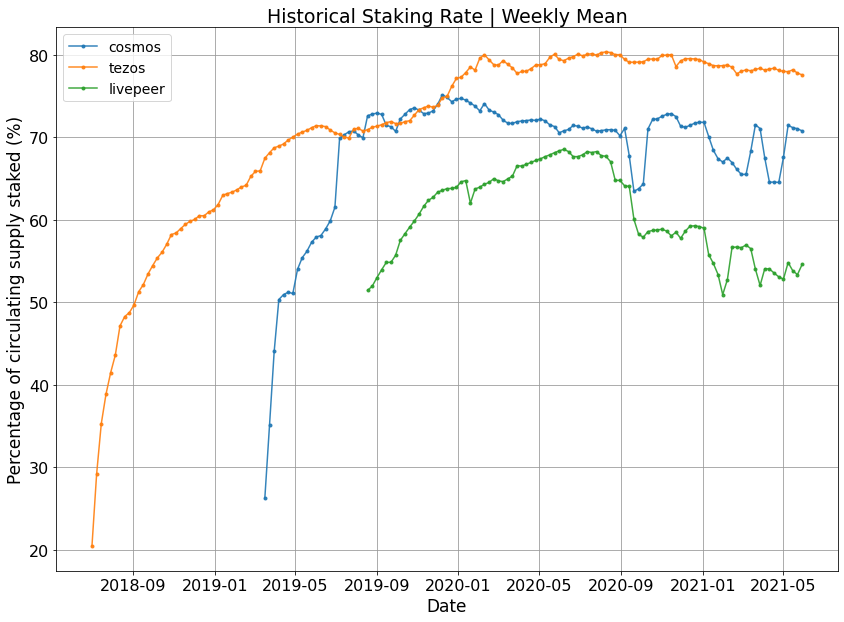

In [78]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    plt.plot(SRnetworks[net]['total_staked'], label = net, alpha=0.9, marker = 'o', ms =3)
plt.title('Historical Staking Rate | Weekly Mean', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Percentage of circulating supply staked (%)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.grid(b=True, which='major', color='#999999', linestyle='-')
#plt.savefig('Hist_SR.pdf')

Since their respective launches, Tezos, Cosmos and Livepeer all saw steadily increases in the staking rate launches, despite the real yields' correspondingly steady decline. Of the three networks, only Livepeer has seen any meaningful reduction in the staking rate, with the other two networks having experienced an elevated staking rate from late 2019 until mid-2021. 

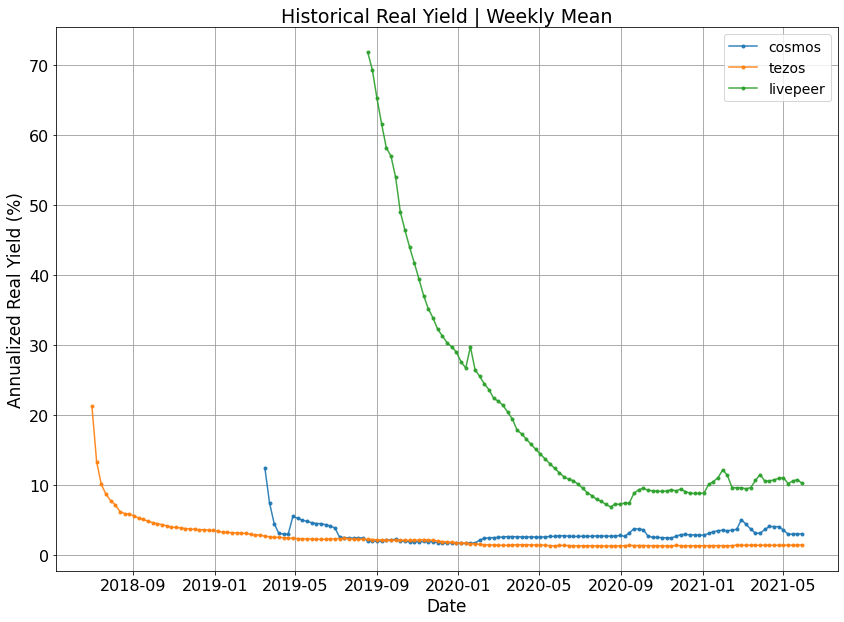

In [79]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    plt.plot(SRnetworks[net]['adjustedReward'], label = net, alpha=0.9, marker = 'o', ms =3)
plt.title('Historical Real Yield | Weekly Mean', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Annualized Real Yield (%)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=0, fontsize=14)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')
#plt.savefig('Hist_RY.pdf')

#### Lagged pearson cross-correlation evaluation

The times series for all three networks and both variables exhibit time-dependent/trending structure in their raw form, and hence are almost certainly non-stationary. The time series are also strongly correlated with themselves, confirmed via standard tests. Though fairly common in time series data, this lack of stationarity renders the results of both Pearson cross-correlation and Granger predictive causality tests far less meaningful. Non-stationarity can be partially or fully remedied with data transformation techniques. The first transformation step is detrending, which involves generating a linear regression of the time series, then subtracting this trendline from the data. This reduces the time-dependency of the series. The next transformation step is differencing, which reduces the autocorrelation of the data. The transformed data are also run through an Augmented Dickey-Fuller test to confirm sufficient stationarity.

In [80]:
def lump(df, size):
    for column in df:
        df[column] = df[column].groupby(np.arange(len(df))//size).mean()
        
def detrend(df):
    for column in df:
        days = [i for i in range(0,len(df[column]))]
        days = np.reshape(days, (len(days), 1))
        model = LinearRegression()
        col_values = df[column]
        model.fit(days, df[column])
        col_trend = model.predict(days)
        detrended_col_values = [col_values[i] - col_trend[i] for i in range(0, len(df[column]))]
        df[column] = detrended_col_values
        
def dif(df):
    for column in df:
        df[column] = df[column].diff(periods=-1)
        
def ipl(df):
    for column in df:
        df[column] = df[column].interpolate(method = 'linear', limit_direction = 'both')
        
def manual_downsample(df):
    for column in df:
        df[column] = df[column].rolling(2).mean() 
        df[column] = df[column].iloc[::2, :]

If the staking rate at a given timestamp is indeed a function of the real yield at some (presently unknown) preceding timestamp, as wide a range of time-lags as possible must be evaluated. This involves shifting the real yield time series against the staking rate time series. Since the network protocols under examination are deliberately designed such that the real yield value is an inverse function of the staking rate at the corresponding timestamp, it is not possible to discern a relationship in the reverse direction (real yield influencing staking) at a time-lag of zero. However, rules surrounding the ceasing of staking (the unbonding delay) mean that unambiguous causality would not surface at a time-lag of zero in any case.

The raw data contain between 4 and 11 entries per day. Anecdotally, stakers and delegators are unlikely to make decisions relating to their stake size every few hours. Indeed, even if a staker programmed an instantaneous response to fluctuations in the real yield, any evidence of causality would be obfuscated by the reverse, known impact of the staking rate on the real yield. Nonetheless, we cannot assume the cadence with which they react to the real yield, if they do at all. Nor would this cadence be uniform across a diverse population of stakers and delegators that have heterogeneous planning horizons and bonding/unbonding frequency preferences. Hence, we downsample the data to daily, weekly, bi-monthly and monthly durations, using the arithmetic mean for both real yield and staking rate variables.

In order to gauge a wider range of possible staker reactions to variable incentives, the analysis converts each real yield entry, based on the native token's exchange rate to USD, and includes this as a separate result on all graphs.

In [81]:
def lag_Pcorr(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    results = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        results[i*lump] = df_temp[feature].corr(df[target])
        df_temp[feature] = df[feature]
    return results

def lag_Scorr(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    results = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        results[i*lump] = df_temp[feature].corr(df[target], method='spearman')
        df_temp[feature] = df[feature]
    return results

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def lag_Pcorr_PV(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    p_values = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        p_values[i*lump] = df_temp[feature].corr(df[target], method=pearsonr_pval)
        df_temp[feature] = df[feature]
    return p_values

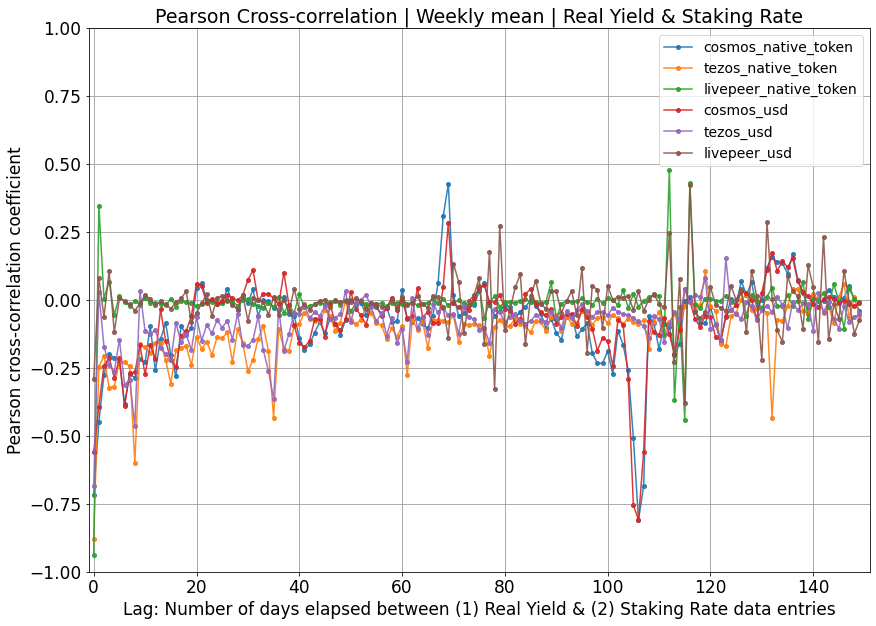

In [82]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
f = 365 #daily
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('D').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'adjustedReward', 'total_staked', int(365/f))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'aRUSD', 'total_staked',int(365/f))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Weekly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

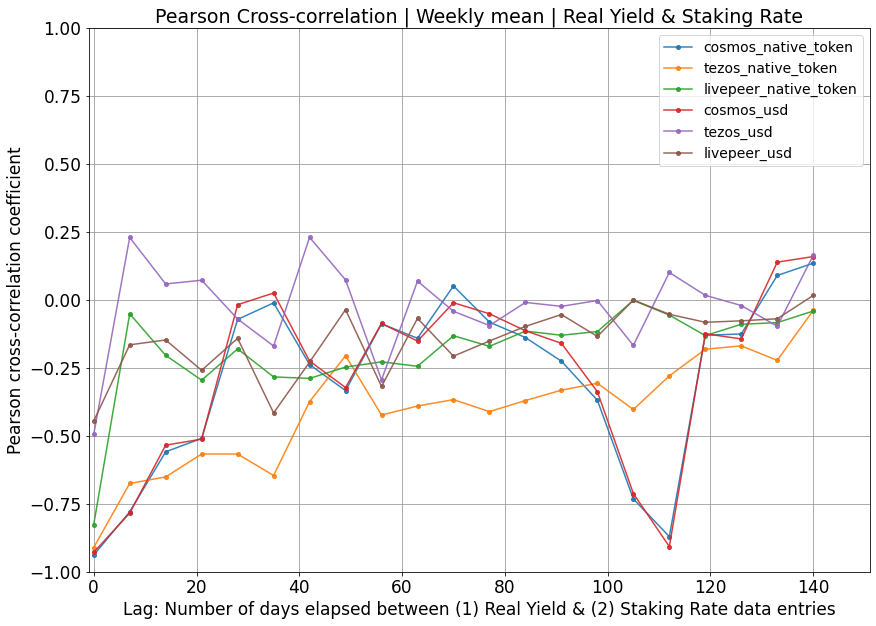

In [83]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
f = 52 #weekly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'adjustedReward', 'total_staked', int(365/f))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'aRUSD', 'total_staked',int(365/f))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Weekly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

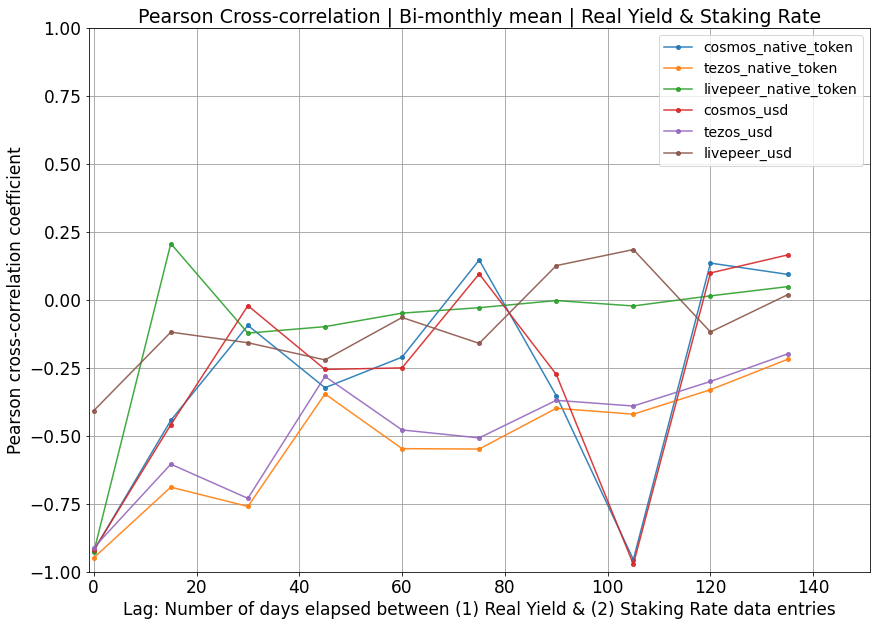

In [84]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
f = 24 #bi-monthly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('SM').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'adjustedReward', 'total_staked', int(365/f))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/int(365/f)), 'aRUSD', 'total_staked', int(365/f))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Bi-monthly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

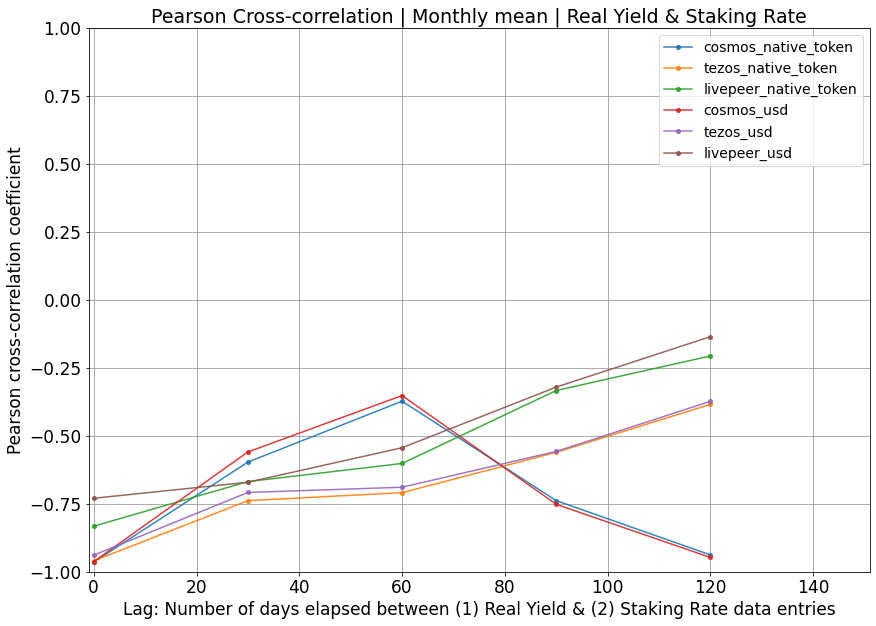

In [85]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
f = 12 #monthly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('m').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/f))), 'adjustedReward', 'total_staked', int(365/f))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/int(365/f)), 'aRUSD', 'total_staked', int(365/f))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Monthly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

A time-lags greater than zero, we are simulating the real yield value occurring first. Hence, when the subsequent staking rate data entry is recorded, the occurrence(s) of previous real yield figure(s) are at least one constituent of the reality in which this new rate occurs.

The Cosmos network statistics exhibit strong negative cross-correlation coefficients, consistently occurring within a time-lag window of 105-120 days. For the native token-denominated results; the daily, weekly, bi-monthly and monthly downsamples show negative coefficients of -0.81, -0.87, -0.96 and -0.94, at time-lags of 106, 112, 105 and 120 days respectively. For the USD-converted results; the weekly, bi-monthly and monthly downsamples show negative coefficients of -0.81, -0.91, -0.97 and -0.95, at time-lags of 106, 112, 105 and 120 days respectively. Each of the p-values corresponding to these negative coefficients imply the result is statistically significant (p $\leq$ 0.05).

The Tezos network statistics exhibit some moderately negative cross-correlations, which get stronger as the downsample duration increases. In the bi-monthly and monthly downsamples, there are negative coefficients (native token-denominated) of -0.76 and -0.74 respectively, both occurring at time-lags of 30 days. Cross-correlation coefficients for the Livepeer network are very weak, across virtually all downsample durations and time-lags.

**No strong and statistically significant positive cross-correlation coefficient is discovered across all downsample durations, time-lags and networks. This is the most notable result and is discussed in depth in the next sections.**

#### Granger predictive causality evaluation 

In order to supplement the results, a Granger test was implemented on the stationarized data, yielding a set of F test p-values over time-lags of 0-150 days. Given the possibility of detrimental feedback loop dynamics, the negative cross-correlations observed in the previous section would be of increased interest if corroborated via these tests. 

In general, Granger causality evaluates the extent to which a series X (in this case, the real yield) lowers the prediction error of a series Y (in this case, the staking rate) when it is included in the model. If the real yield time series provides additional information on the distribution of future values of staking rate, that are not already contained in the past values of the staking rate, then we may claim the presence of granger predictive causality. 

In [86]:
def SSR_F_causality(df, value, predictor, maxlag, downsample):
    lag_chiP = {}
    results = grangercausalitytests(df[[value, predictor]], maxlag=maxlag, verbose=False)
    for i in range(0, maxlag):
        p_value = results[i+1][0]['ssr_ftest'][1]
        lag_chiP[i*downsample] = p_value
    return lag_chiP

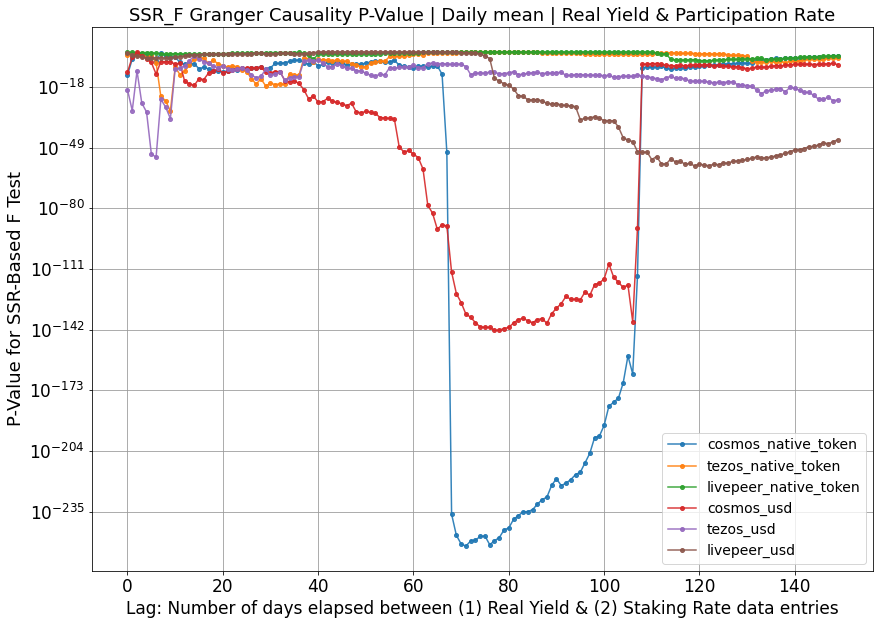

In [87]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_F = {}
SR_F_USD = {}
f = 365 #daily
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('D').mean()
    ipl(SRnetworks[net])
    SR_F[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'adjustedReward', int(150/(int(365/f))), int(365/f))
    SR_F_USD[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'aRUSD', int(150/(int(365/f))),  int(365/f))
    
for net in SR_F:
    lists = sorted(SR_F[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_F_USD:
    lists = sorted(SR_F_USD[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('SSR_F Granger Causality P-Value | Daily mean | Real Yield & Participation Rate', fontsize=18)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('P-Value for SSR-Based F Test', fontsize=18)
plt.legend(loc=4, fontsize=14)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

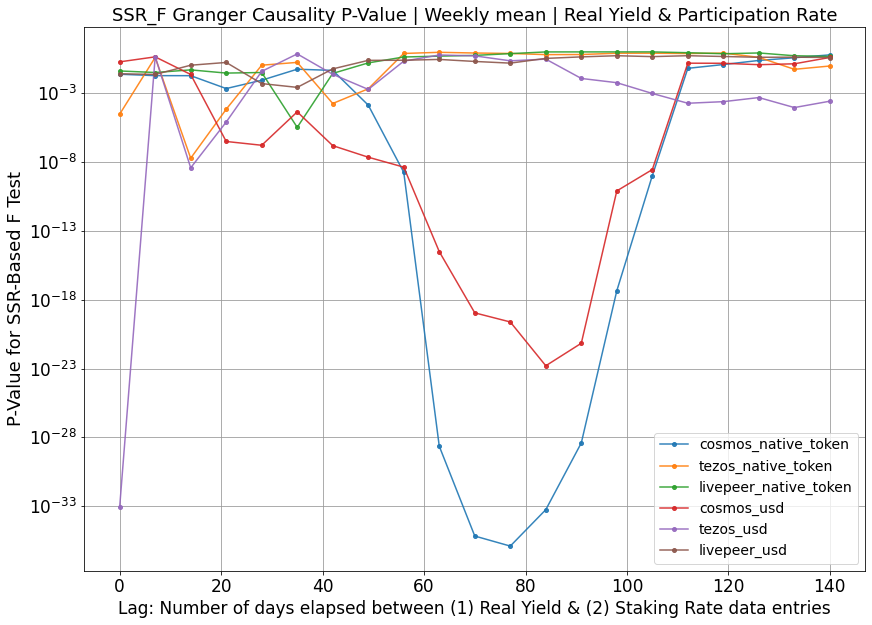

In [88]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_F = {}
SR_F_USD = {}
f = 52 #weekly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    ipl(SRnetworks[net])
    SR_F[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'adjustedReward', int(150/(int(365/f))), int(365/f))
    SR_F_USD[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'aRUSD', int(150/(int(365/f))),  int(365/f))
    
for net in SR_F:
    lists = sorted(SR_F[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_F_USD:
    lists = sorted(SR_F_USD[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('SSR_F Granger Causality P-Value | Weekly mean | Real Yield & Participation Rate', fontsize=18)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('P-Value for SSR-Based F Test', fontsize=18)
plt.legend(loc=4, fontsize=14)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

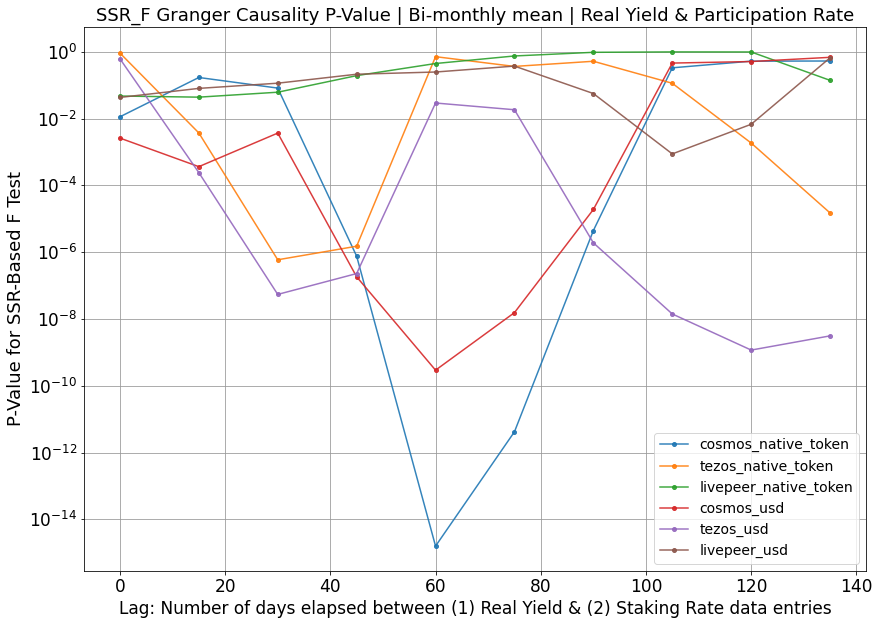

In [89]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_F = {}
SR_F_USD = {}
f = 24 #bi-monthly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('SMS').mean()
    ipl(SRnetworks[net])
    SR_F[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'adjustedReward', int(150/(int(365/f))), int(365/f))
    SR_F_USD[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'aRUSD', int(150/(int(365/f))),  int(365/f))
    
for net in SR_F:
    lists = sorted(SR_F[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_F_USD:
    lists = sorted(SR_F_USD[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('SSR_F Granger Causality P-Value | Bi-monthly mean | Real Yield & Participation Rate', fontsize=18)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('P-Value for SSR-Based F Test', fontsize=18)
plt.legend(loc=4, fontsize=14)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

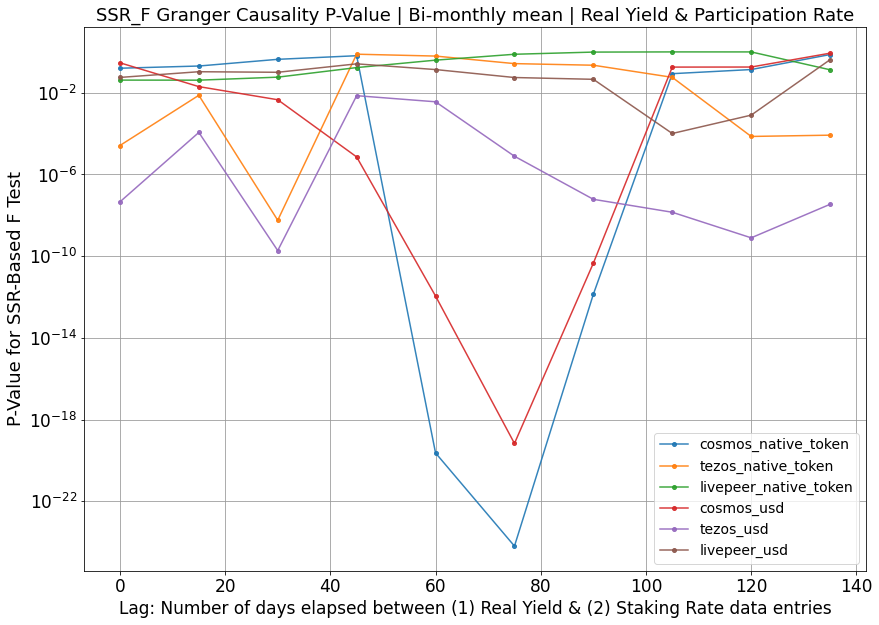

In [90]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_F = {}
SR_F_USD = {}
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('SM').mean()
    ipl(SRnetworks[net])
    SR_F[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'adjustedReward', int(150/(int(365/24))), int(365/24))
    SR_F_USD[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'aRUSD', int(150/(int(365/24))),  int(365/24))
    
for net in SR_F:
    lists = sorted(SR_F[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_F_USD:
    lists = sorted(SR_F_USD[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('SSR_F Granger Causality P-Value | Bi-monthly mean | Real Yield & Participation Rate', fontsize=18)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('P-Value for SSR-Based F Test', fontsize=18)
plt.legend(loc=4, fontsize=14)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

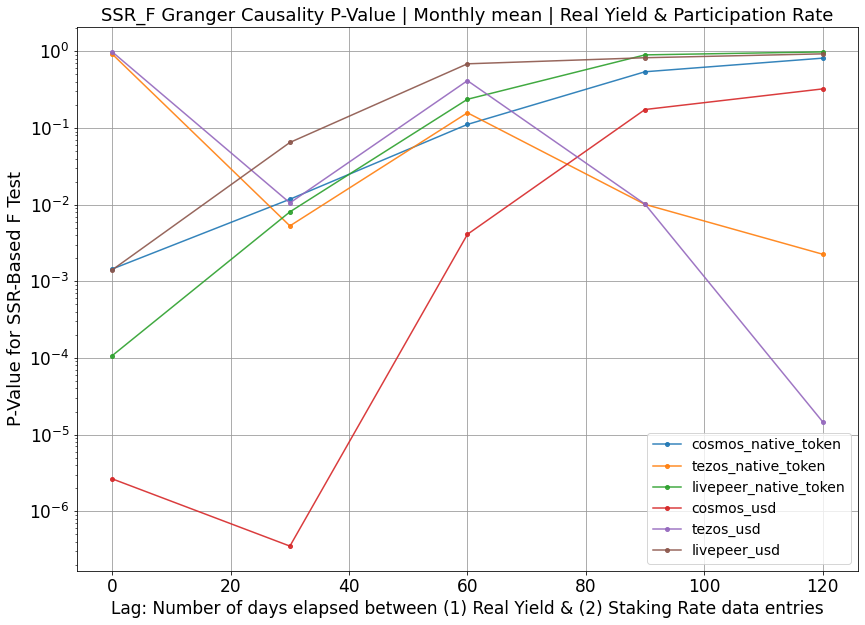

In [91]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_F = {}
SR_F_USD = {}
f = 12 # monthly
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('M').mean()
    ipl(SRnetworks[net])
    SR_F[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'adjustedReward', int(150/(int(365/f))), int(365/f))
    SR_F_USD[net] = SSR_F_causality(SRnetworks[net], 'total_staked', 'aRUSD', int(150/(int(365/f))),  int(365/f))
    
for net in SR_F:
    lists = sorted(SR_F[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_F_USD:
    lists = sorted(SR_F_USD[net].items())
    x, y = zip(*lists)
    plt.plot(x, y,label=net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('SSR_F Granger Causality P-Value | Monthly mean | Real Yield & Participation Rate', fontsize=18)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('P-Value for SSR-Based F Test', fontsize=18)
plt.legend(loc=4, fontsize=14)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

Cosmos's network statistics exhibit the following notable indications of Granger predictive causality. The daily downsample at time-lags of 105, 106 and 107 days, for both native token-denominated and USD-converted results, return p-values that are << 0.05. The results at 105 days directly corroborate the strong negative coefficients at the equivalent time-lag unearthed in the previous section. The weekly downsample at time-lags of 98 and 105 days, for both native token-denominated and USD-converted results, return p-values that are << 0.05. However, the negative coefficients for weekly downsamples in the previous section occurred at a time-lag of 112 days, which here return predictive causality p-values of 0.06 and 0.14 for native token-denominated and USD-converted results respectively. The bi-monthly downsample at a time-lag of 90 days, for both native token-denominated and USD-converted results, return p-values that are << 0.05. However, the negative coefficients for bi-monthly downsamples in the previous section occurred at a time-lag of 105 days, which here return predictive causality p-values of 0.08 and 0.18 for native token-denominated and USD-converted results respectively. The monthly downsample did not generate any predictive causality p-values of note. 

Although only Cosmos's daily downsample provides a strict corroboration of previous results (that is, precisely the same time-lag), there are are a number of neighboring time-lags for other downsample durations that exhibit evidence of Granger predictive causality. This substantiates claims of a delayed, inverse and potentially causal relationship between the real yield and staking rate, and that this effect tends to occur 2-4 months after the initial change in real yield. Given that staking rates have mostly risen since Cosmos's network launch, we may attribute this negative cross-correlation to stakers increasing their stake size following a reduction in real yields. The strategies and dynamics that would explain this phenomenon are covered in the next sections. 
    
We also note that Tezos's moderately negative cross-coefficients are corroborated by Granger predictive causality tests, wherein the monthly downsample, at a time-lag of 30 days, generates p-values of 0.005 and 0.01 for native token-denominated and USD-converted results respectively. We further note that the vast majority of predictive causality tests for Livepeer data generate results that are not statistically significant (p > 0.05). 

#### Related Work

The susceptibility of Proof-of-Stake networks to sub-optimum outcomes is increasingly under the spotlight. Particularly germane to this analysis is research which warns of long-term, unintended and value proposition-threatening consequences, and posits the reward mechanism's design as the primary culprit. There is a growing body of work critiquing the function through which rewards are generated and allocated. The most oft-cited economic risk, advanced by Fanti et al. [3], Wang et al. [4], and He et al. [5], albeit with differing explanations, is the eventual concentration of wealth amongst network stakeholders. This paper's results show that prevailing strategic choices which engender oversupply overlap with a subset of the conditions which can foment wealth concentration. For example, stake hoarding, a behavior introduced by Deuber et al. and alluded to by He et al., appears to contribute to both unwelcome outcomes. Moreover, the downstream impact of chronically elevated staking exacerbates the advantages of larger stakers, which contributes to wealth concentration and centralization. 

There is a notable disagreement in the literature with respect to the allegation that generic Proof-of-Stake reward mechanisms contain an autogenous wealth concentrating function. Fanti et al. contend that the reward recipient selection function (weighting by stake size with imbued randomness; a configuration of stochastic reinforcement) combined with the facilitation of compounding, precipitate 'rich get richer' outcomes. Wang et al. agree with this premise, asserting that reward functions are typically aligned with stake accumulation. Conversely, Rosu and Saleh claim that stake shares, over time, satisfy the martingale condition. In another paper, Saleh reiterates this, demonstrating that an arbitrary fractional share at genesis should equal the _expected_ fractional share after protracted reward distribution.

This analysis, which presents evidence of stake accumulation, wholly uninhibited by variable incentives, overlaps with investigations into fractional share evolution in Proof-of-Stake networks, the long-term outcomes of which remain unresolved analytically and empirically. For example, there is anecdotal evidence that certain Proof-of-Stake networks, including those under examination in this paper, have suffered some degree of wealth concentration. However, the temporal evolution remains unclear. For example, an analysis from He et al. , which includes the assertion that stakers (above a certain wealth threshold) will continue to stake until the real yield reaches its theoretical minimum, dovetails with this paper's conclusions. Modeling a staking protocol as having two classes of staker with respect to the size of their collateral ('big' & 'small'), He et al. also provide proof that any increase in the external capital available to smaller stakers, and the commensurate augmentation of their stakes (in an attempt to reach the equilibrium return rate), will predictably increase the overall staking rate. This is despite bigger stakers reducing their stake size in response to this new capital injection by smaller stakers, also in an attempt to reach the equilibrium return rate.

In a similar vein, Deuber et al. posit the issue of token/stake hoarding; their definition of utility maximization not necessitating liquid tokens (e.g. for trading). Their game theoretic proofs support this paper's conclusions, in helping explain why short-term fluctuations in the real yield are largely irrelevant to a payoff strategy with long-term horizons. Deuber et al also argue that these conditions lead to effective deflation, which jeopardizes the token's use as a form of payment. Finally, they substantiate the stake hoarding phenomenon empirically by presenting the relative dearth of transactions following the genesis token distribution of various Proof-of-Stake networks.

Although there are overlaps with aforementioned research inasmuch as diagnosing problems with the reward mechanism, the weaknesses highlighted in this paper are borne out of a higher-level design choice; that is, leveraging supply growth as the means of sourcing value, obligating the true value of the reward to be tied to the fraction of total token-holders who receive it. Hitherto, the literature has not focused on the frailties of the reward mechanism from this 'macro' perspective, nor the impact (or lack thereof) on the staking rate, nor the risks of perennial oversupply.

At this macro resolution, Irresberger [6] does briefly allude to staker participation, their ostensible axiom that targeting a specific staking rate is a valuable property of a hypothetical reward mechanism. In their simulations, dynamic adjustment of the reward leads to high staking rates, which fits with this paper's analysis. However, they do not question whether an elevated staking rate is positive for the network.

#### Interpretation of results 

The outcome of greatest significance is the absence of a solitary result to substantiate the hypothesis that stakers and delegators react to fluctuations in the real yield in the manner expected by reward mechanism designers. Across the combinations of time-lag and downsample duration, the cross-correlation coefficients that are consistently strong and statistically significant occur at a time-lag of zero days. This holds true when further data transformations are applied, including second-order differencing, and when the same evaluation is applied to the real yield earned by delegators. Years into the networks' existence, we cannot yet make an empirically substantiated claim that decreasing real yields are prompting decreasing staking. If decreasing real yields fail to motivate a reduction in committed capital, or even worse, incentivize increased commitment, then networks must either modify the reward mechanism or rely on new exogenous factors to induce a scale-back in capacity. At first glance, the reward budget stretched thin appears to benefit nobody. However, deeper-pocketed stakers are the most likely to survive sustained epochs of market oversupply, which can increase their fractional share of the token supply – this 'outlast and consolidate' strategy is discussed in this section.

A bivariate analysis cannot prove the absence of a causal relationship beyond doubt, nor that modeling stakers as predominantly preferring to (1) plan for maximum utility over short-term horizons and (2) bond/unbond on a regular basis, is necessarily fallacious. It remains possible that some unknown variable explains the results, whilst accommodating the reality of decreasing real yields followed by increasing staking rates. However, the fact remains that, regardless of dynamics unbeknownst to researchers, long periods of very low real yields have failed to dissuade service-providers and delegators from collectively staking more and more tokens. Many factors influence staker behavior, but clearly staking protocols are failing to provide a sufficiently strong disincentive (or sufficiently weak incentive) to overcome said factors. To assess the future efficacy of the reward mechanism in regulating the staking rate, we evaluate three major factors that influence the decision to bond or unbond capital, besides the real yield.

#### Consolidation strategies and vicious circles

The networks under examination, and indeed many others, are designed such that the allocation of work (e.g. proposing blocks), and therefore the opportunity to earn transaction fees, is at least partially weighted on relative stake size. This means that access to future income is predicated on the percentage of the staked supply that a staker _will_ control. Decentralized network governance – the mechanisms through which key protocol parameters, including those related to reward/fee allocation, are updated, also weigh votes on upgrade proposals by fractional token share. Though Tezos delegators may switch staker if they don’t like the way they are voting, this set-up still motivates all token-holders to secure their power over network upgrades via maximizing their accumulation of tokens. 

The ramifications are acute; any token that is liquidated, loaned out, or even just left temporarily unbonded, will cost the holder future earnings and power, and this loss compounds over time as other stakers add rewards to their stake. Unless a staker absolutely needs to liquidate rewards to pay for ongoing operational costs, a rational strategy is attempting to outlast the competition, given the possibility that the competitor will be forced to liquidate their rewards or part of their stake sooner, thereby increasing the surviving staker's relative control – increasing current earnings, and compounding future earnings. Hence, with deep enough pockets, it is rational to undertake a long-term consolidation strategy and maximize the number of tokens one stakes, irrespective of how small the real yield is. A model of stakers as homogeneous utility maximizers from He et al., arrives at a comparable conclusion, wherein the equilibrium rate-of-return for staking is equal to a bank's risk-free rate. In other words, stakers compete with one another and 'overinvest' until any extra real yield over the baseline falls to zero.

One way this scenario could arise is through a detrimental feedback loop, or vicious circle. The analysis unearthed statistically significant instances of time-lagged negative cross-correlations, partially corroborated by a Granger predictive causality tests. Overall, the coefficients were far more negative than positive, particularly for bi-monthly and monthly downsamples. It is eminently plausible that a staker might react to a diminished reward by increasing their stake size. Ceteris paribus, they would now receive an increased reward over the next few rounds, and perhaps return to sustainable income levels. Of course, their action would further reduce the income of their peers, which may in turn prompt them to employ the very same strategy. In this way, we eventually arrive at an equilibrium where return is equal to, or even below, the risk-free interest rate.

#### Footnotes & References

[1] Variable block generation times and non-programmatic events also impact the circulating supply and therefore the true value of issued tokens. An example of the latter is a network’s foundation, treasury or reserve releasing new tokens into the supply, outside of a public reward schedule. However, the fluctuating staking rate and global dilution account for almost the entire difference between the nominal inflation rate and the real yield, and so other factors of this kind are discounted in this analysis.

[2] Deuber et al https://link.springer.com/chapter/10.1007%2F978-3-030-57808-4_16

[3] Fanti et al https://arxiv.org/pdf/1809.07468.pdf

[4] Wang et al https://www.sciencedirect.com/science/article/pii/S0020025520302784?via%3Dihub
 
[5] He et al https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3609817

[6] Irresberger https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3293694